# Deep learning models for GTSRB dataset

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

from sklearn.model_selection import train_test_split
from imgaug import augmenters as aug

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

### Auxiliar functions

In [59]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames



def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label



def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()



def show_batch(image_batch, label_batch):
  columns = 8
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')



def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    



def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()    



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()



def convert_to_png(data, opt="Y"):
    if opt == 'Y':
        for i in range (43):

            path = os.path.join(data, format(i, '05d'))
            files = os.listdir(path)
            csv = ""

            for file in files:
                try:
                    image = Image.open(os.path.join(path,file))
                    image.save(f"{path}/{file.split('.')[0]}.png")
                except:
                    pass
        print(f'Finished converting all files in {data} into png files.') 
    elif opt == 'N': 
        print(f'Recieved the option that disables png conversion.\n  Dataset: {data} remains unchanged...') 
    else:
        print(f'Invalid flag...')



def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)



def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')
    


def display_smpl(data_gen, title):
    classes = dict()
    for key,val in data_gen.class_indices.items():
        classes[val] = key
    sample_img, sample_lbl = next(data_gen)
    plt.figure(figsize=(10,3))
    plt.subplots_adjust(hspace=0.5)
    for n in range(5):
        plt.subplot(1, 5, n+1)
        plt.imshow(sample_img[n])
        plt.title(classes[np.argmax(sample_lbl[n])])
        plt.axis("off")
        _ = plt.suptitle(title)   



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(8,6))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

### Batch size

* [1]  https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [60]:
BATCH_SIZE = 32
IMAGE_SIZE = 32

DIMENTION = (IMAGE_SIZE, IMAGE_SIZE)

#### Other Default values

Subject to change

In [61]:
data = []

N_CLASSES = 43
N_CHANNELS = 3
KERNEL_SIZE = (5,5)
N_EPOCHS = 25

TRAIN_ONLINE = True

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Paths

In [62]:
data_path = 'c:/Users/Utilizador/Documents/GitHub/VCPI-Grupo/Datasets/train_images'
test_path = 'c:/Users/Utilizador/Documents/GitHub/VCPI-Grupo/Datasets/test_images'
logs_path = 'c:/Users/Utilizador/Documents/GitHub/VCPI-Grupo/Logs'

### Verifying how many classes the dataset has

In [63]:
class_names = np.array(os.listdir(f'{data_path}'))


print("Classes present in the dataset: \n")    
class_names # Better format this output
    

Classes present in the dataset: 



array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

### Load data

In some functions of **tf.keras.preprocessing** the format *.ppm* isn't supported by them. That beeing said, it was developed a function capable of converting every single *.ppm* file into a *.png* readable by the preprocessing functions.

In addition, this function has an option that enables and disables the conversion of the images, "Y" to enable and "N" to disable.

In [64]:
convert_to_png(data_path, "N")

convert_to_png(test_path, "N")

Recieved the option that disables png conversion.
  Dataset: c:/Users/Utilizador/Documents/GitHub/VCPI-Grupo/Datasets/train_images remains unchanged...
Recieved the option that disables png conversion.
  Dataset: c:/Users/Utilizador/Documents/GitHub/VCPI-Grupo/Datasets/test_images remains unchanged...


In [65]:
# train_data_gen = tf.keras.preprocessing.image_dataset_from_directory(
#     f'{data_path}',
#     label_mode='categorical',
#     image_size=(32,32),
#     shuffle=True
# ) # This might be wrong: if I put batch_size it breaks
# 
# normalize = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
# train_data_gen = train_data_gen.map(lambda x, y: (normalize(x), y))
# 
# 
# test_data_gen = tf.keras.preprocessing.image_dataset_from_directory(
#     f'{test_path}',
#     label_mode='categorical',
#     image_size=(32,32),
#     shuffle=True
# ) # This might be wrong: if I put batch_size it breaks
# 
# normalize = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
# test_data_gen = test_data_gen.map(lambda x, y: (normalize(x), y))

train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=5)
train_data_gen = train_img_gen.flow_from_directory(directory=data_path, shuffle=True, target_size=DIMENTION) # Change True to False

test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_img_gen.flow_from_directory(directory=test_path, shuffle=True, target_size=DIMENTION) # Change True to False

Found 39209 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


### Showing Images

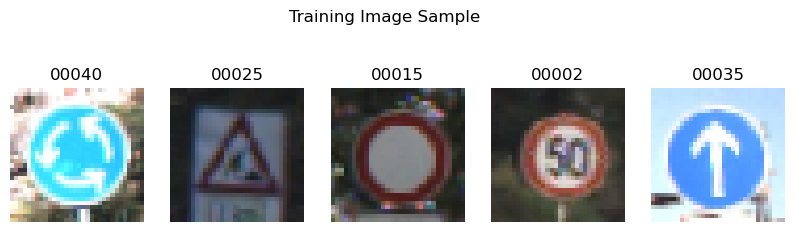

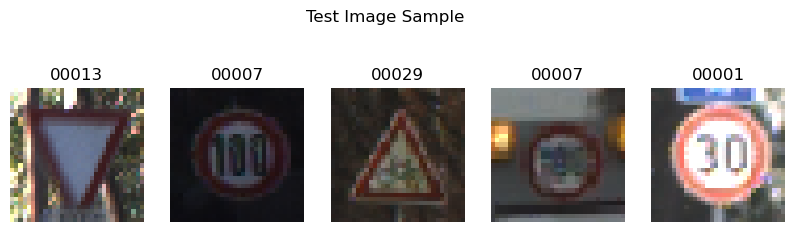

In [66]:
display_smpl(train_data_gen, "Training Image Sample")
display_smpl(test_data_gen, "Test Image Sample")

### Model creation

In [67]:
num_classes = len(train_data_gen.class_indices)

model = tf.keras.Sequential([tf.keras.layers.Input(shape=(28,28,1)), tf.keras.layers.Flatten(), tf.keras.layers.Dense(256, activation='relu'), tf.keras.layers.Dense(256, activation='relu'), tf.keras.layers.Dense(num_classes, activation='softmax')])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 43)                11051     
Total params: 277,803
Trainable params: 277,803
Non-trainable params: 0
_________________________________________________________________


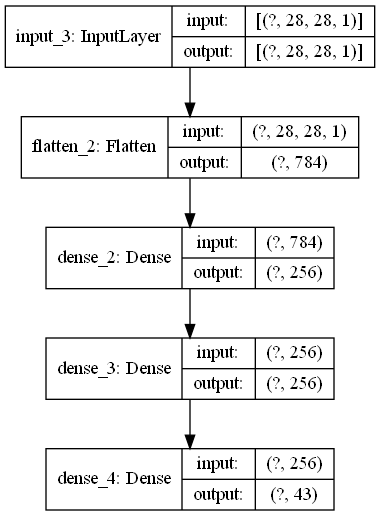

In [68]:
tf.keras.utils.plot_model(model,show_shapes=True)

#### Callback definition

In [69]:
def prepare_callbacks(file_path):
    
    pointer = ModelCheckpoint(filepath=file_path, monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True)
    stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1)
    reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0)
    
    return [pointer, stopper, reduceLr]

### Model Fitting

In [70]:
train_step = np.ceil(train_data_gen.samples/train_data_gen.batch_index)

### Data Augmentation

Add more augments to the list

In [71]:
augment_1 = aug.GaussianBlur(sigma=(0, 2.0)) 
augment_2 = aug.AdditiveGaussianNoise(0, 0.05 * 255)

In [72]:
def apply_augmentation(img, opt=2): 
    if opt == 1:
        img = augment_1(img)
        return img
    elif opt == 2:
        img = augment_2(img)
        return img
    else:
        print("Invalid augment option...")